In [ ]:
import yfinance as yf
import pandas as pd
import os

ed = yf.Ticker("ED")
ed = ed.history(period="max")
ed.to_csv("ed.csv")
ed.index = pd.to_datetime(ed.index)
ed

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02 00:00:00-05:00,0.000000,0.266382,0.262334,0.262334,25600,0.0,0.0
1962-01-03 00:00:00-05:00,0.000000,0.264358,0.262334,0.262334,28800,0.0,0.0
1962-01-04 00:00:00-05:00,0.000000,0.263953,0.261524,0.261524,21600,0.0,0.0
1962-01-05 00:00:00-05:00,0.000000,0.259905,0.255857,0.255857,46400,0.0,0.0
1962-01-08 00:00:00-05:00,0.000000,0.259905,0.256262,0.257071,29600,0.0,0.0
...,...,...,...,...,...,...,...
2023-09-11 00:00:00-04:00,88.639999,90.080002,88.639999,89.730003,1627600,0.0,0.0
2023-09-12 00:00:00-04:00,89.879997,90.330002,88.790001,90.199997,1815500,0.0,0.0
2023-09-13 00:00:00-04:00,90.500000,91.629997,90.260002,91.459999,1725200,0.0,0.0


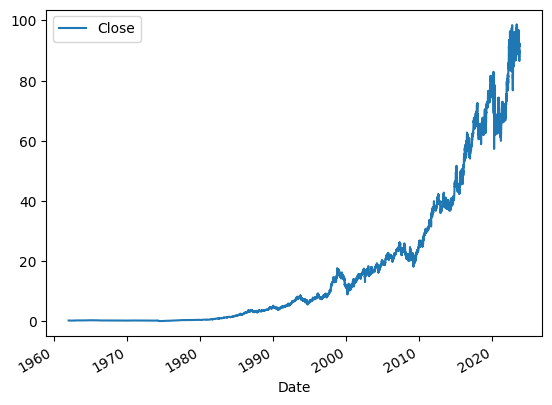

In [ ]:
ed.plot.line(y="Close", use_index=True)

del ed["Dividends"]
del ed["Stock Splits"]

ed["Tomorrow"] = ed["Close"].shift(-1)

ed["Target"] = (ed["Tomorrow"] > ed["Close"]).astype(int)

ed = ed.loc["2001-08-05":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = ed.iloc[:-100]
test = ed.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4603174603174603

<Axes: xlabel='Date'>

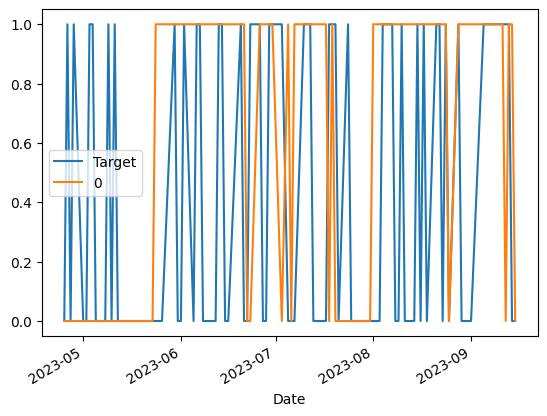

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

predictions = backtest(ed, model, predictors)

predictions["Predictions"].value_counts()

0    1633
1    1430
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5454545454545454

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.534117
0    0.465883
Name: Target, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = ed.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    ed[ratio_column] = ed["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    ed[trend_column] = ed.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
ed = ed.dropna(subset=ed.columns[ed.columns != "Tomorrow"])

ed

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2005-08-01 00:00:00-04:00,22.005863,22.046944,21.741118,21.745682,1037500,22.088022,1,0.994572,0.0,0.990560,2.0,1.027298,35.0,1.108681,137.0,1.258054,517.0
2005-08-02 00:00:00-04:00,21.818712,22.110845,21.818712,22.088022,1050400,22.211271,1,1.007810,1.0,1.004651,3.0,1.041724,35.0,1.125149,138.0,1.277349,517.0
2005-08-03 00:00:00-04:00,22.060641,22.471453,22.037817,22.211271,1016300,22.083462,0,1.002782,2.0,1.007913,3.0,1.045895,35.0,1.130466,138.0,1.283940,518.0
2005-08-04 00:00:00-04:00,22.129107,22.229528,22.046944,22.083462,697100,21.736546,0,0.997115,1.0,1.002777,2.0,1.038366,34.0,1.122998,138.0,1.276050,517.0
2005-08-05 00:00:00-04:00,21.978470,21.987597,21.535705,21.736546,1162200,21.312035,0,0.992083,0.0,0.989239,2.0,1.021071,33.0,1.104508,137.0,1.255544,516.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 00:00:00-04:00,88.639999,90.080002,88.639999,89.730003,1627600,90.199997,1,1.002682,2.0,1.017809,4.0,0.987136,27.0,0.982589,117.0,1.137527,518.0
2023-09-12 00:00:00-04:00,89.879997,90.330002,88.790001,90.199997,1815500,91.459999,1,1.002612,2.0,1.014646,5.0,0.992667,27.0,0.987962,118.0,1.143333,518.0
2023-09-13 00:00:00-04:00,90.500000,91.629997,90.260002,91.459999,1725200,92.379997,1,1.006936,2.0,1.018145,5.0,1.006657,28.0,1.001986,118.0,1.159135,518.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(ed, model, new_predictors)

predictions["Predictions"].value_counts()

0.0    1869
1.0     194
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5618556701030928

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.539506
0    0.460494
Name: Target, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2015-07-08 00:00:00-04:00,0,0.0
2015-07-09 00:00:00-04:00,1,0.0
2015-07-10 00:00:00-04:00,0,0.0
2015-07-13 00:00:00-04:00,0,0.0
2015-07-14 00:00:00-04:00,1,0.0
...,...,...
2023-09-11 00:00:00-04:00,1,0.0
2023-09-12 00:00:00-04:00,1,0.0
2023-09-13 00:00:00-04:00,1,0.0
